In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = "Dataset/TrainDataaaa/001/001-Train1.JPG"

blurSigma = 1.0
otsuThreshold = 0

freqThreshold = 10

neighborDistance = 50

In [3]:
angle = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
angle = angle * np.pi / 180

sin = np.sin(angle)
cos = np.cos(angle)

d = np.array([neighborDistance, 0])
delta = np.zeros((16, 2))

for i in range(16):
      delta[i] = np.dot(np.array([[cos[i], -sin[i]], [sin[i], cos[i]]]), d)

def nonValleySuppression(img, candidate):
    rows, cols = img.shape
    newCandidate = np.zeros((0, 2))

    for c in candidate:
        neighbor = np.round(c + delta).astype(np.int64)
        neighbor = neighbor[(neighbor[:, 1] >= 0) & (neighbor[:, 1] < rows) & (neighbor[:, 0] >= 0) & (neighbor[:, 0] < cols)]
        value = img[neighbor[:, 1], neighbor[:, 0]]

    # Determine whether a hand-valley or not
        count = np.sum(value == 0)
        if count <= 7:
            newCandidate = np.append(newCandidate, c.reshape(1, 2).astype(np.int64), axis = 0)

    return newCandidate

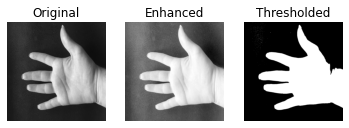

In [4]:
original = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
try:
    original = cv2.resize(original,(1024,1024),3)
except:
    print("Hata")
#original = cv2.resize(original,(1024,1024))
# Smoothing
blurred = cv2.GaussianBlur(original, (0, 0), blurSigma)

# Lightening
c = 255 / np.log(np.max(blurred) + 1)
enhanced = (c * np.log(blurred + 1)).astype(np.uint8)

# Thresholding
retval, thresholded = cv2.threshold(enhanced, otsuThreshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        

fig, aarr = plt.subplots(1, 3)

aarr[0].imshow(original, cmap = "gray")
aarr[0].set_title("Original")
aarr[0].axis("off")

aarr[1].imshow(enhanced, cmap = "gray")
aarr[1].set_title("Enhanced")
aarr[1].axis("off")

aarr[2].imshow(thresholded, cmap = "gray")
aarr[2].set_title("Thresholded")
aarr[2].axis("off")

plt.show()

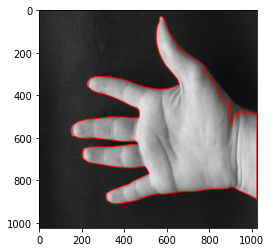

In [5]:
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]

area = [cv2.contourArea(contour) for contour in contours]

order = np.argmax(area)
contour = contours[order]

boundary = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
cv2.drawContours(boundary, contour, -1, (255, 0, 0), 3)

plt.imshow(boundary)
plt.show()

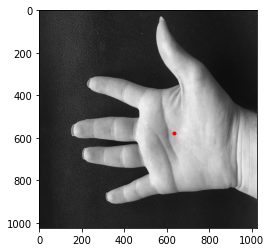

In [6]:
moments = cv2.moments(contour)
center = [moments['m10'] // moments['m00'], moments['m01'] // moments['m00']]

plt.imshow(original, cmap = "gray")
plt.plot(center[0], center[1], "ro", markersize = 3)
plt.show()

In [7]:
# Calculating distances
contour = contour[:, 0, :]
distance = np.sqrt(np.sum((contour - center) ** 2, axis = 1)).reshape(-1)

# Low-pass filtering
freq = np.fft.rfft(distance)
newFreq = np.concatenate([freq[:freqThreshold], 0 * freq[freqThreshold:]])
newDistance = np.fft.irfft(newFreq)

# Derivation
derivation = np.diff(newDistance)
zeroCrossing = np.diff(np.sign(derivation)) / 2

# Local minima
candidate = contour[np.where(zeroCrossing > 0)[0]]

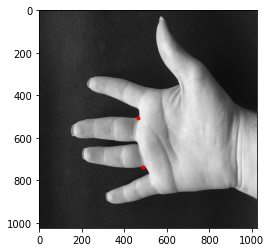

In [8]:


# CHVD algorithm
candidate = nonValleySuppression(thresholded, candidate)

# Three left most valleys
order = np.argsort(candidate[:, 0])
candidate = candidate[order]
candidate = candidate[:3]

# Top and bottom valleys of the triad
order = np.argsort(candidate[:, 1])
valley = candidate[[order[0], order[2]]]

plt.imshow(original, cmap = "gray")
plt.plot(valley[:, 0], valley[:, 1], "ro", markersize = 3)
plt.show()

C:\Users\Akdeniz\AppData\Local\Temp\ipykernel_2444\3527680796.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
C:\Users\Akdeniz\AppData\Local\Temp\ipykernel_2444\3527680796.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

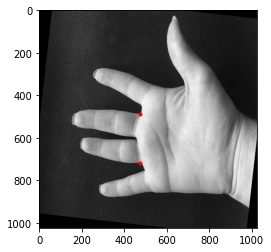

In [9]:
valley0, valley1 = valley
phi = - 90 + np.arctan2((valley1 - valley0)[1], (valley1 - valley0)[0]) * 180 / np.pi

R = cv2.getRotationMatrix2D(tuple(center), phi, 1)
rotated = cv2.warpAffine(original, R, original.shape[::-1])

valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
valley1 = (np.dot(R[:, :2], valley1) + R[:, -1]).astype(np.int)

plt.imshow(rotated, cmap = "gray")
plt.plot(valley0[0], valley0[1], "ro", markersize = 3)
plt.plot(valley1[0], valley1[1], "ro", markersize = 3)
plt.show()

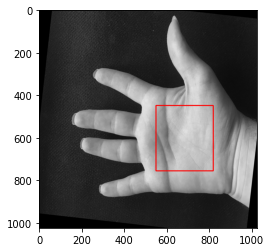

In [10]:
rect0 = (valley0[0] + 2 * (valley1[1] - valley0[1]) // 6, valley0[1] - (valley1[1] - valley0[1]) // 6)
rect1 = (valley1[0] + 9 * (valley1[1] - valley0[1]) // 6, valley1[1] + (valley1[1] - valley0[1]) // 6)

marked = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
cv2.rectangle(marked, rect0, rect1, (255, 0, 0), 3)

plt.imshow(marked, cmap = "gray")
plt.show()

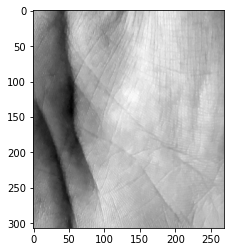

In [11]:
roiGray = rotated[rect0[1]:rect1[1], rect0[0]:rect1[0]]

plt.imshow(roiGray, cmap = "gray")
plt.show()

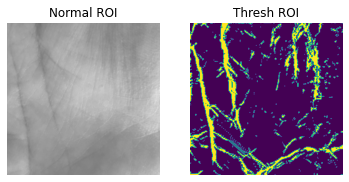

In [13]:

roiNormal = cv2.cvtColor(roiGray, cv2.COLOR_BGR2RGB)
#fig, aarr = plt.subplots(1, 2)
#aarr[0].imshow(roiGray, cmap = "gray")
#aarr[1].imshow(roiNormal)

#plt.show()

grayCPY = cv2.cvtColor(roiNormal, cv2.COLOR_BGR2GRAY)
noise = cv2.fastNlMeansDenoising(grayCPY)
noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

  # equalist hist
kernel = np.ones((7,7),np.uint8)
img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)


# invert
inv = cv2.bitwise_not(img_output)

    # erode
grayCPY = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
erosion = cv2.erode(grayCPY,kernel,iterations = 1)

    # skel
img = grayCPY.copy()
skel = img.copy()
skel[:,:] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7,7))
iterations = 0
#print("dongu")
while True:
    eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
    temp  = cv2.subtract(img, temp)
    skel = cv2.bitwise_or(skel, temp)
    img[:,:] = eroded[:,:]
    if cv2.countNonZero(img) == 0:
        break

ret, Thresh = cv2.threshold(skel, 7,255, cv2.THRESH_BINARY);
Thresh = cv2.resize(Thresh, (512,512))
roiNormal = cv2.resize(roiNormal, (512,512))

fig, aarr = plt.subplots(1, 2)
aarr[0].imshow(roiNormal, cmap = "gray")
aarr[0].set_title("Normal ROI")
aarr[0].axis("off")
aarr[1].imshow(Thresh)
aarr[1].set_title("Thresh ROI")
aarr[1].axis("off")
plt.show()

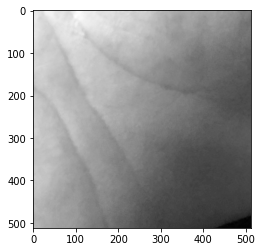

In [183]:
roiThreshhh = cv2.cvtColor(roiNormal, cv2.COLOR_RGB2GRAY)
plt.imshow(roiThreshhh, cmap = "gray")